# Deep Learning Model Implementation Using PyTorch & Brainwave Data
- Saint Cloud State University (SCSU), Avatar Open Source Project Issue #299
- Created by: Giovanni Antunez

## Objectives

- Create a deep learning model using PyTorch and Brainwave data that could be used to identify drone commands. 
<br>
- Compare performance/results between this new PyTorch model and the existing TensorFlow implementation
<br>
- Create a pull request to add PyTorch implementation and trained model to the directory Avatar/deep-learning-prediction/pytorch.
<br>
<br>

## Packages/Libraries

In [ ]:
# Use for data processing
import pathlib
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Use for model evaluation
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Use for PyTorch model implementation
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset

# Use for data visualizations
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preparation

### Get Files

In [ ]:
## Load Brainwave data - electroencephalography (EEG) signals

# get directory
directory_path = "/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/"  # Replace with your desired path

core_dir = pathlib.Path(directory_path)
skip_dirs = ["Group1-8channels"]

# get data
dfs = []

for item in core_dir.rglob("*.txt"):
    try:
        if set(item.parts).isdisjoint(skip_dirs):
            df = pd.read_csv(item, sep=",", header=4, on_bad_lines="skip")
            df["src_filename"] = str(item)
            dfs.append(df)
            print(f"Read {item}")
    except Exception as e:
        print(f"Failed to read {item}: {e}")

Read /Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt
Read /Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-29-30.txt
Read /Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-31-37.txt
Read /Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-29-52.txt
Read /Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-54.txt
Read /Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-31-15.txt
Read /Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-28-30.txt
Read /Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-29-10.txt
Read /Users/projects/Avatar/Data/EEG_Sig

In [ ]:
dfs[:10]

[      Sample Index   EXG Channel 0   EXG Channel 1   EXG Channel 2  \
 0              0.0   -10308.468081   -29738.034873   -30354.920668   
 1            234.0   -10306.724645   -29722.790983   -30360.955639   
 2            236.0   -10315.933563   -29729.250637   -30363.011999   
 3            238.0   -10302.544868   -29725.048509   -30361.827357   
 4            240.0   -10303.438938   -29732.491640   -30360.307438   
 ...            ...             ...             ...             ...   
 1402         226.0   -10484.152792   -29762.264164   -30162.181576   
 1403         228.0   -10474.318024   -29755.268068   -30154.604334   
 1404         230.0   -10487.192629   -29764.074655   -30165.891965   
 1405         232.0   -10491.931199   -29776.725742   -30175.547919   
 1406         234.0   -10486.298559   -29775.362286   -30170.898756   
 
        EXG Channel 3   EXG Channel 4   EXG Channel 5   EXG Channel 6  \
 0      -28563.696571   -34551.885373     4293.613648     2120.979383   


### Combine data

In [ ]:
# combine
eeg_data = pd.concat(dfs, ignore_index=True)

/var/folders/hy/wf0skdmx4rl_d17yyv_qmtdr0000gn/T/ipykernel_1123/2650804897.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  eeg_data = pd.concat(dfs, ignore_index=True)


In [ ]:
eeg_data.columns

Index(['Sample Index', ' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2',
       ' EXG Channel 3', ' EXG Channel 4', ' EXG Channel 5', ' EXG Channel 6',
       ' EXG Channel 7', ' EXG Channel 8', ' EXG Channel 9', ' EXG Channel 10',
       ' EXG Channel 11', ' EXG Channel 12', ' EXG Channel 13',
       ' EXG Channel 14', ' EXG Channel 15', ' Accel Channel 0',
       ' Accel Channel 1', ' Accel Channel 2', ' Not Used',
       ' Digital Channel 0 (D11)', ' Digital Channel 1 (D12)',
       ' Digital Channel 2 (D13)', ' Digital Channel 3 (D17)', ' Not Used.1',
       ' Digital Channel 4 (D18)', ' Analog Channel 0', ' Analog Channel 1',
       ' Analog Channel 2', ' Timestamp', ' Marker Channel',
       ' Timestamp (Formatted)', 'src_filename'],
      dtype='object')

In [ ]:
eeg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1790486 entries, 0 to 1790485
Data columns (total 34 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Sample Index              float64
 1    EXG Channel 0            float64
 2    EXG Channel 1            float64
 3    EXG Channel 2            float64
 4    EXG Channel 3            float64
 5    EXG Channel 4            float64
 6    EXG Channel 5            float64
 7    EXG Channel 6            float64
 8    EXG Channel 7            float64
 9    EXG Channel 8            float64
 10   EXG Channel 9            float64
 11   EXG Channel 10           float64
 12   EXG Channel 11           float64
 13   EXG Channel 12           float64
 14   EXG Channel 13           float64
 15   EXG Channel 14           float64
 16   EXG Channel 15           float64
 17   Accel Channel 0          float64
 18   Accel Channel 1          float64
 19   Accel Channel 2          float64
 20   Not Used               

In [ ]:
eeg_data.head(10)

,Sample Index,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,EXG Channel 4,EXG Channel 5,EXG Channel 6,EXG Channel 7,EXG Channel 8,...,Digital Channel 3 (D17),Not Used.1,Digital Channel 4 (D18),Analog Channel 0,Analog Channel 1,Analog Channel 2,Timestamp,Marker Channel,Timestamp (Formatted),src_filename
0,0.0,-10308.468081,-29738.034873,-30354.920668,-28563.696571,-34551.885373,4293.613648,2120.979383,31336.184601,0.000000,...,16.0,124.5,64.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.330,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt
1,234.0,-10306.724645,-29722.790983,-30360.955639,-28565.976449,-34551.572448,4294.194793,2128.221348,31360.972686,-20353.364391,...,0.0,0.0,0.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.330,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt
2,236.0,-10315.933563,-29729.250637,-30363.011999,-28565.797635,-34545.246905,4304.789520,2115.391447,31335.894029,-20346.100074,...,0.0,0.0,0.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.330,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt
3,238.0,-10302.544868,-29725.048509,-30361.827357,-28566.915222,-34544.710463,4303.627229,2136.513846,31353.082520,-20338.411073,...,0.0,0.0,0.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.330,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt
4,240.0,-10303.438938,-29732.491640,-30360.307438,-28575.297126,-34546.364492,4308.119930,2119.146540,31333.949427,-20340.109806,...,0.0,0.0,0.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.330,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt
5,242.0,-10302.321351,-29736.291437,-30361.737950,-28566.848167,-34546.118623,4307.829357,2130.612985,31335.379939,-20340.132158,...,0.0,124.5,72.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.330,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt
6,244.0,-10309.116281,-29736.045568,-30366.945907,-28574.000725,-34552.019483,4304.633058,2119.861796,31325.902799,-20336.377065,...,0.0,0.0,0.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.330,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt
7,246.0,-10319.889822,-29745.120376,-30374.813721,-28582.002650,-34555.439300,4295.848822,2120.062962,31334.061186,-20347.262364,...,0.0,0.0,0.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.330,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt
8,248.0,-10316.715874,-29744.539230,-30371.483311,-28582.874368,-34554.232306,4298.978066,2111.256374,31335.290532,-20347.843510,...,0.0,0.0,0.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.330,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt
9,0.0,-5212.069179,-14901.528049,-15155.622680,-14237.614183,-17230.892745,2151.310700,1163.654168,15505.159259,-10171.161314,...,0.0,124.5,56.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.475,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt


### Get Labels

In [ ]:
## Set Labels

# create a final dataset to update
eeg_data_fnl = eeg_data

# update label text
eeg_data_fnl["label_txt"] = ""
label_names = ["backward", "forward", "landing", "left", "right", "takeoff", "fowward"]

for label in label_names:
    eeg_data_fnl["label_txt"] = np.where(
        (eeg_data_fnl["label_txt"] == "")
        & eeg_data_fnl["src_filename"].str.lower().str.contains(label),
        label,
        eeg_data_fnl["label_txt"],
    )

# rename fowward to forward
eeg_data_fnl["label_txt"] = np.where(
    eeg_data_fnl["label_txt"] == "fowward", "forward", eeg_data_fnl["label_txt"]
)  # TODO: Is there a better way to handle these files named incorrectly?

In [ ]:
# see records by label
print(eeg_data_fnl.groupby(["label_txt"])["Sample Index"].count())

label_txt
backward    292975
forward     298097
landing     299873
left        297775
right       297856
takeoff     303910
Name: Sample Index, dtype: int64


In [ ]:
# validate counts at the file name level as needed
pd.set_option("display.max_colwidth", None)
print(eeg_data_fnl.groupby(["label_txt", "src_filename"])["Sample Index"].count())

label_txt  src_filename                                                                                                          
backward   /Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Backward/OpenBCI-RAW-2025-03-12_15-10-29.txt     1287
           /Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Backward/OpenBCI-RAW-2025-03-12_15-10-49.txt     1579
           /Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Backward/OpenBCI-RAW-2025-03-12_15-11-09.txt     1259
           /Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Backward/OpenBCI-RAW-2025-03-12_15-11-27.txt     1291
           /Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Backward/OpenBCI-RAW-2025-03-12_15-11-47.txt     1338
                                                                                                                                     ... 
takeoff    /Users/projects/Avatar/Data/EEG

In [ ]:
eeg_data_fnl.head(10)

,Sample Index,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,EXG Channel 4,EXG Channel 5,EXG Channel 6,EXG Channel 7,EXG Channel 8,...,Not Used.1,Digital Channel 4 (D18),Analog Channel 0,Analog Channel 1,Analog Channel 2,Timestamp,Marker Channel,Timestamp (Formatted),src_filename,label_txt
0,0.0,-10308.468081,-29738.034873,-30354.920668,-28563.696571,-34551.885373,4293.613648,2120.979383,31336.184601,0.000000,...,124.5,64.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.330,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt,right
1,234.0,-10306.724645,-29722.790983,-30360.955639,-28565.976449,-34551.572448,4294.194793,2128.221348,31360.972686,-20353.364391,...,0.0,0.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.330,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt,right
2,236.0,-10315.933563,-29729.250637,-30363.011999,-28565.797635,-34545.246905,4304.789520,2115.391447,31335.894029,-20346.100074,...,0.0,0.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.330,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt,right
3,238.0,-10302.544868,-29725.048509,-30361.827357,-28566.915222,-34544.710463,4303.627229,2136.513846,31353.082520,-20338.411073,...,0.0,0.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.330,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt,right
4,240.0,-10303.438938,-29732.491640,-30360.307438,-28575.297126,-34546.364492,4308.119930,2119.146540,31333.949427,-20340.109806,...,0.0,0.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.330,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt,right
5,242.0,-10302.321351,-29736.291437,-30361.737950,-28566.848167,-34546.118623,4307.829357,2130.612985,31335.379939,-20340.132158,...,124.5,72.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.330,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt,right
6,244.0,-10309.116281,-29736.045568,-30366.945907,-28574.000725,-34552.019483,4304.633058,2119.861796,31325.902799,-20336.377065,...,0.0,0.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.330,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt,right
7,246.0,-10319.889822,-29745.120376,-30374.813721,-28582.002650,-34555.439300,4295.848822,2120.062962,31334.061186,-20347.262364,...,0.0,0.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.330,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt,right
8,248.0,-10316.715874,-29744.539230,-30371.483311,-28582.874368,-34554.232306,4298.978066,2111.256374,31335.290532,-20347.843510,...,0.0,0.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.330,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt,right
9,0.0,-5212.069179,-14901.528049,-15155.622680,-14237.614183,-17230.892745,2151.310700,1163.654168,15505.159259,-10171.161314,...,124.5,56.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.475,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt,right


In [ ]:
# encode labels
le = LabelEncoder()
eeg_data_fnl["label"] = le.fit_transform(eeg_data_fnl["label_txt"])

In [ ]:
eeg_data_fnl.head(10)

,Sample Index,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,EXG Channel 4,EXG Channel 5,EXG Channel 6,EXG Channel 7,EXG Channel 8,...,Digital Channel 4 (D18),Analog Channel 0,Analog Channel 1,Analog Channel 2,Timestamp,Marker Channel,Timestamp (Formatted),src_filename,label_txt,label
0,0.0,-10308.468081,-29738.034873,-30354.920668,-28563.696571,-34551.885373,4293.613648,2120.979383,31336.184601,0.000000,...,64.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.330,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt,right,4
1,234.0,-10306.724645,-29722.790983,-30360.955639,-28565.976449,-34551.572448,4294.194793,2128.221348,31360.972686,-20353.364391,...,0.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.330,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt,right,4
2,236.0,-10315.933563,-29729.250637,-30363.011999,-28565.797635,-34545.246905,4304.789520,2115.391447,31335.894029,-20346.100074,...,0.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.330,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt,right,4
3,238.0,-10302.544868,-29725.048509,-30361.827357,-28566.915222,-34544.710463,4303.627229,2136.513846,31353.082520,-20338.411073,...,0.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.330,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt,right,4
4,240.0,-10303.438938,-29732.491640,-30360.307438,-28575.297126,-34546.364492,4308.119930,2119.146540,31333.949427,-20340.109806,...,0.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.330,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt,right,4
5,242.0,-10302.321351,-29736.291437,-30361.737950,-28566.848167,-34546.118623,4307.829357,2130.612985,31335.379939,-20340.132158,...,72.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.330,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt,right,4
6,244.0,-10309.116281,-29736.045568,-30366.945907,-28574.000725,-34552.019483,4304.633058,2119.861796,31325.902799,-20336.377065,...,0.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.330,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt,right,4
7,246.0,-10319.889822,-29745.120376,-30374.813721,-28582.002650,-34555.439300,4295.848822,2120.062962,31334.061186,-20347.262364,...,0.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.330,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt,right,4
8,248.0,-10316.715874,-29744.539230,-30371.483311,-28582.874368,-34554.232306,4298.978066,2111.256374,31335.290532,-20347.843510,...,0.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.330,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt,right,4
9,0.0,-5212.069179,-14901.528049,-15155.622680,-14237.614183,-17230.892745,2151.310700,1163.654168,15505.159259,-10171.161314,...,56.0,0.0,0.0,0.0,1.741811e+09,0.0,2025-03-12 15:30:14.475,/Users/projects/Avatar/Data/EEG_Signals/brainwave_readings/Group1/Test10/Right/OpenBCI-RAW-2025-03-12_15-30-14.txt,right,4


In [ ]:
print("Classes:", le.classes_)

Classes: ['backward' 'forward' 'landing' 'left' 'right' 'takeoff']


In [ ]:
print(eeg_data_fnl.groupby(["label_txt", "label"])["Sample Index"].count())

label_txt  label
backward   0        292975
forward    1        298097
landing    2        299873
left       3        297775
right      4        297856
takeoff    5        303910
Name: Sample Index, dtype: int64


### Create final dataset for train & test splits

In [ ]:
# eeg_data_fnl = eeg_data_fnl.sample(n = 10000) # just for testing code

X = eeg_data_fnl.iloc[:, 1:17]
y = pd.DataFrame(eeg_data_fnl.iloc[:, -1])

In [ ]:
X[" EXG Channel 0"].count()

np.int64(1790486)

In [ ]:
X.head(10)

,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,EXG Channel 4,EXG Channel 5,EXG Channel 6,EXG Channel 7,EXG Channel 8,EXG Channel 9,EXG Channel 10,EXG Channel 11,EXG Channel 12,EXG Channel 13,EXG Channel 14,EXG Channel 15
0,-10308.468081,-29738.034873,-30354.920668,-28563.696571,-34551.885373,4293.613648,2120.979383,31336.184601,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-10306.724645,-29722.790983,-30360.955639,-28565.976449,-34551.572448,4294.194793,2128.221348,31360.972686,-20353.364391,-27879.375563,-30934.702567,4258.543761,-40346.306902,-18896.410632,1438.714735,11445.769542
2,-10315.933563,-29729.250637,-30363.011999,-28565.797635,-34545.246905,4304.789520,2115.391447,31335.894029,-20346.100074,-27864.802225,-30934.724919,4267.707976,-40332.359413,-18881.211445,1445.487314,11437.857024
3,-10302.544868,-29725.048509,-30361.827357,-28566.915222,-34544.710463,4303.627229,2136.513846,31353.082520,-20338.411073,-27863.662286,-30930.902771,4266.031595,-40331.621806,-18878.976271,1415.759494,11429.318658
4,-10303.438938,-29732.491640,-30360.307438,-28575.297126,-34546.364492,4308.119930,2119.146540,31333.949427,-20340.109806,-27865.428074,-30930.902771,4263.125868,-40330.861846,-18883.580730,1438.960605,11436.404161
5,-10302.321351,-29736.291437,-30361.737950,-28566.848167,-34546.118623,4307.829357,2130.612985,31335.379939,-20340.132158,-27866.679772,-30931.282751,4261.829467,-40329.118410,-18880.004451,1404.449511,11423.395446
6,-10309.116281,-29736.045568,-30366.945907,-28574.000725,-34552.019483,4304.633058,2119.861796,31325.902799,-20336.377065,-27866.858586,-30931.439213,4271.463069,-40332.024137,-18877.903387,1435.630195,11437.074713
7,-10319.889822,-29745.120376,-30374.813721,-28582.002650,-34555.439300,4295.848822,2120.062962,31334.061186,-20347.262364,-27874.547586,-30948.650056,4257.537932,-40341.300111,-18891.917931,1397.833395,11425.272992
8,-10316.715874,-29744.539230,-30371.483311,-28582.874368,-34554.232306,4298.978066,2111.256374,31335.290532,-20347.843510,-27875.732228,-30951.667541,4266.255112,-40345.189315,-18894.130754,1432.232729,11435.331277
9,-5212.069179,-14901.528049,-15155.622680,-14237.614183,-17230.892745,2151.310700,1163.654168,15505.159259,-10171.161314,-13937.050275,-15470.201131,2135.597424,-20170.907101,-9444.394343,694.781625,5715.966906


In [ ]:
y.head(10)

,label
0,4
1,4
2,4
3,4
4,4
5,4
6,4
7,4
8,4
9,4


In [ ]:
y.shape

(1790486, 1)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, 16)

print(f"Datatype:: {type(X_scaled)}")

Datatype:: <class 'numpy.ndarray'>


In [ ]:
## Create Tensors

import numpy as np

# create a numpy array from dataframe
y_array = y.to_numpy()

# create a Tensor from numpy array
X = torch.tensor(X_scaled).type(torch.float)
y = torch.tensor(y_array).type(torch.LongTensor).squeeze()


# get shape, datatype, and device
print(f"Shape of X tensor: {X.shape}")
print(f"Datatype of X tensor: {X.dtype}")
print(f"Device X tensor is stored on: {X.device}")
print(f"Shape of y tensor: {y.shape}")
print(f"Datatype of y tensor: {y.dtype}")
print(f"Device y tensor is stored on: {y.device}")

Shape of X tensor: torch.Size([1790486, 16])
Datatype of X tensor: torch.float32
Device X tensor is stored on: cpu
Shape of y tensor: torch.Size([1790486])
Datatype of y tensor: torch.int64
Device y tensor is stored on: cpu


### Create train/test splits

In [ ]:
# use sklearn's train test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,  # use for reproducibility
)

print("X train shape:" + str(X_train.shape))
print("y train shape:" + str(y_train.shape))
print("X test shape:" + str(X_test.shape))
print("y test shape:" + str(y_test.shape))

X train shape:torch.Size([1432388, 16])
y train shape:torch.Size([1432388])
X test shape:torch.Size([358098, 16])
y test shape:torch.Size([358098])


### Utilize PyTorch Dataset & Dataloader utilities to prep data for model training
- Dataset will be used to retrieve features & labels
- Dataloader will be used to access & pass samples in "mini batches", reshuffle the data at every epoch to reduce model overfitting
- Ref: https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [ ]:
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=True)

## Create Model & Training

### Create Model

In [ ]:
# Create model class
class FlexibleCNNClassifier(
    nn.Module
):  # Defines a custom class, must subclass nn.Module to access functions
    def __init__(self, num_classes=6):
        super(
            FlexibleCNNClassifier, self
        ).__init__()  # used for initialization, required for every PyTorch model

        # Two 1D convolutional layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(
            in_channels=64, out_channels=128, kernel_size=3, padding=1
        )
        self.pool = nn.MaxPool1d(2)  # max pooling to control overfitting
        self.global_pool = nn.AdaptiveAvgPool1d(
            1
        )  # shrinks sequence length to 1, needed before feeding to fully connected (Linear) layers

        # Two Linear layers
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(
            64, num_classes
        )  # map to the # of output classes, which is 6

    def forward(
        self, x
    ):  # Defines how data will be passed through the layers, using ReLU (introduces nonlinearity, which is important for learning complex patterns)
        if x.dim() == 2:
            x = x.unsqueeze(1)

        x = F.relu(self.conv1(x))
        x = self.pool(x) if x.shape[-1] > 1 else x
        x = F.relu(self.conv2(x))
        x = self.pool(x) if x.shape[-1] > 1 else x

        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Model Summary
model = FlexibleCNNClassifier(num_classes=6)
summary(model, input_size=(1, 16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 16]             256
         MaxPool1d-2                [-1, 64, 8]               0
            Conv1d-3               [-1, 128, 8]          24,704
         MaxPool1d-4               [-1, 128, 4]               0
 AdaptiveAvgPool1d-5               [-1, 128, 1]               0
            Linear-6                   [-1, 64]           8,256
            Linear-7                    [-1, 6]             390
Total params: 33,606
Trainable params: 33,606
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.13
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


### Model Training

In [ ]:
# Loss, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Training Loop
def evaluate(model, loader):  # function to evaluate model using test data
    model.eval()
    correct, total, val_loss = 0, 0, 0.0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    return val_loss / len(loader), correct / total


for epoch in range(5):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()  # clears old gradients

        # Compute prediction error
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backpropagation
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    val_loss, val_acc = evaluate(model, test_loader)

    print(
        f"Epoch {epoch + 1}: "
        f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.3f}, "
        f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.3f}"
    )

Epoch 1: Train Loss=0.4963, Train Acc=0.815, Val Loss=0.1697, Val Acc=0.949
Epoch 2: Train Loss=0.1319, Train Acc=0.966, Val Loss=0.0821, Val Acc=0.980
Epoch 3: Train Loss=0.0998, Train Acc=0.975, Val Loss=0.0571, Val Acc=0.988
Epoch 4: Train Loss=0.0821, Train Acc=0.981, Val Loss=0.0474, Val Acc=0.990
Epoch 5: Train Loss=0.0720, Train Acc=0.983, Val Loss=0.0661, Val Acc=0.979


## Model Evaluation

In [ ]:
# Predict the classes with the model
# Make predictions
model.eval()
with torch.inference_mode():
    logits = model(X_test)

# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(logits, dim=1)

# predictions = model(X_test)
predicted_classes = torch.argmax(y_pred_probs, dim=1)
true_classes = y_test

In [ ]:
# get accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 97.94%


In [ ]:
# create a classification report to see model performance on test data (ie precision, recall, f1, and accuracy)
report = classification_report(
    true_classes,
    predicted_classes,
    target_names=["Backward", "Forward", "Left", "Right", "Land", "Takeoff"],
)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

    Backward       0.98      0.96      0.97     58636
     Forward       1.00      0.99      0.99     59601
        Left       0.97      0.98      0.98     59852
       Right       0.98      0.95      0.97     59850
        Land       0.96      0.99      0.98     59565
     Takeoff       0.98      1.00      0.99     60594

    accuracy                           0.98    358098
   macro avg       0.98      0.98      0.98    358098
weighted avg       0.98      0.98      0.98    358098



In [ ]:
# create a confusion matrixx
conf_matrix = confusion_matrix(true_classes, predicted_classes)


conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=["Backward", "Forward", "Left", "Right", "Land", "Takeoff"],
    columns=["Backward", "Forward", "Left", "Right", "Land", "Takeoff"],
)

print("Confusion Matrix:")
print(conf_matrix_df)

Confusion Matrix:
          Backward  Forward   Left  Right   Land  Takeoff
Backward     56159      143   1045    960     18      311
Forward         19    59093    408     18     21       42
Left            14        8  58845      6    364      615
Right          935       21     19  56841   2034        0
Land             1        4     43     38  59264      215
Takeoff          2       15     19     15     32    60511


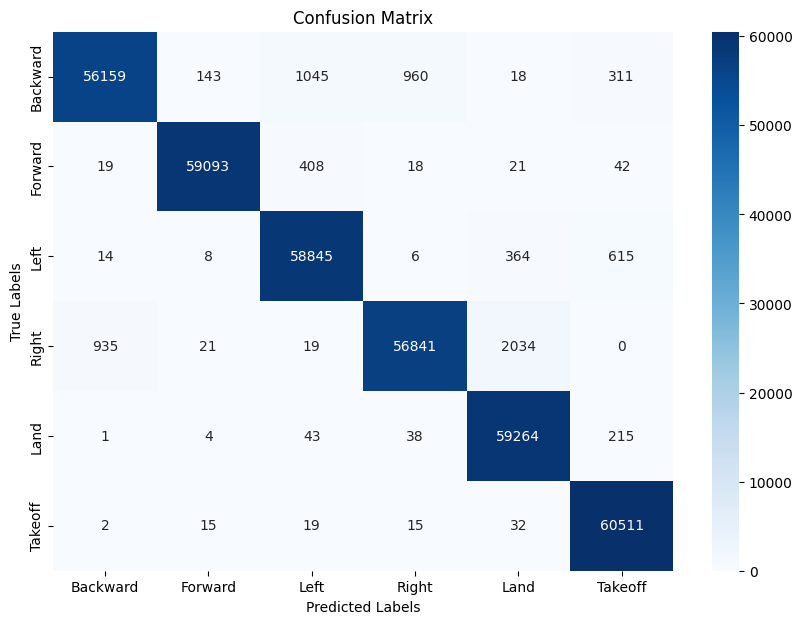

In [ ]:
# create a confusion matrix with a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Backward", "Forward", "Left", "Right", "Land", "Takeoff"],
    yticklabels=["Backward", "Forward", "Left", "Right", "Land", "Takeoff"],
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.savefig("ConfusionMatrix.png")
plt.show()

## Saving & Loading Model


### Saving
- Per pytorch documentation it is recommended to Save/Load state_dict (https://docs.pytorch.org/tutorials/beginner/saving_loading_models.html)

In [ ]:
model_directory = "/Users/projects/Avatar/Models/"
model_name = model.__class__.__name__ + ".pth"
PATH = model_directory + model_name

torch.save(model.state_dict(), PATH)

In [ ]:
print(model.__class__.__name__)

FlexibleCNNClassifier


### Loading

In [ ]:
model_directory = "/Users/projects/Avatar/Models/"
PATH = (
    model_directory + "FlexibleCNNClassifier_Version1.pth"
)  # Version 1 corresponds to the model trained in this demo (99.57% accuracy)

In [ ]:
model = FlexibleCNNClassifier(num_classes=6)
model.load_state_dict(torch.load(PATH, weights_only=True))
model.eval()

FlexibleCNNClassifier(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=6, bias=True)
)

## Future Considerations

- Streamline data preparation steps wherever possible
- Address failure to read one file
- Increase training & test dataset by collecting & utilizing brain signal data from more individuals
- Add early stop to model
- Train model using GPUs instead of CPU
- Add more comments & references to code to further explain sections